In [1]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import sys
import gc
from pprint import pprint
sys.path.append("../src")
from sklearn.base import TransformerMixin, BaseEstimator
import re
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from config import data_dir
from data_loader import DataLoader, DatasetFilename
from tqdm import tqdm
from data.transformers import OneHotEncoderWithMemory

# auto reload all modules
%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis

In this notebook we want to understand what kind of data we have before approaching feature engineering.

* What information do the datasets contain
* Is there any missing data
* Investigating outliers (are they due to entry error?)
* Look at target variable
    * what is correlated with the target
    
At the end we want to know:
* how imbalanced is our data
* do we need to fill in / drop missing data
* do wee need to handle outliers
* restrict set of columns used in feature engineering

In [2]:
# get a list fo available datasets
data_io = DataLoader()
data_io.list_available()

['applications',
 'bureau_balance',
 'bureau',
 'credit_card_balance',
 'installments_payments',
 'previous_applications',
 'cash_balance']

In [3]:
#data_io.load_all()

for d in tqdm(['applications']):
    data_io.load_dataset(d)

  0%|                                                                     | 0/1 [00:00<?, ?it/s]2022-05-16 21:21:56 logger [322] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-05-16 21:21:59 logger [322] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 3.2541}
100%|█████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


In [4]:
data_io.list_loaded()

['applications']

## Dataset: application

In [5]:
print(f'Number of samples in the training set: {data_io["applications"].shape[0]:,}')

pct = (data_io['applications'].target.value_counts() \
    / data_io['applications'].shape[0] * 100)
pct.index = ['not defaulted', 'defaulted']
pct.round(1).astype(str).apply(lambda s: s+'%')

Number of samples in the training set: 307,511


not defaulted    91.9%
defaulted         8.1%
Name: target, dtype: object

We have over 300k samples for training, but about a heavily imbalanced datset. About 92% of applications had no default. In this case, we cannot focus on comman classification metric such as accuracy, since a model would learn to always predict no defult, and be highly accurate with a score of 92%. To mitigate this issue, later we can use a numer of techniques designed to address this problem. 

1. Focus on alternative metrics such as precision, recall, and f1-score (a compromise between the previous two). We can also take a look at ROC-AUC and PR scores.
2. Use class weights, i.e. weight minority class samples with a higher weight.
3. Over- and undersampling, to artificially balance the dataset.
4. Threshold moving - choosing a different cutoff than 0.5

We will address all of these techniques in the modelling section.

**Baseline**: currently about 8% of disbursed application default, which we will use as a baseline. Our MVP model should show at least as good results on a test set. In other words, it is worth continuing with the project if we can get False Negative rate of 8% or better (lower). If we are able to reach 8%, our solution is worth implementing for automation purposes (removing the cost of manual processing, time spent etc). If we can beat this rate, our project will reduce costs of non-repayed loans as well.

In [6]:
# shorter variable name for convinience
df = data_io['applications']
df.head(1)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,cash loans,m,n,y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Cleaning

Before diving into data analysis, let's check out for missing values and anomalies, the presence of which can affect the perceived relationship between the features and the target variable.

<AxesSubplot:>

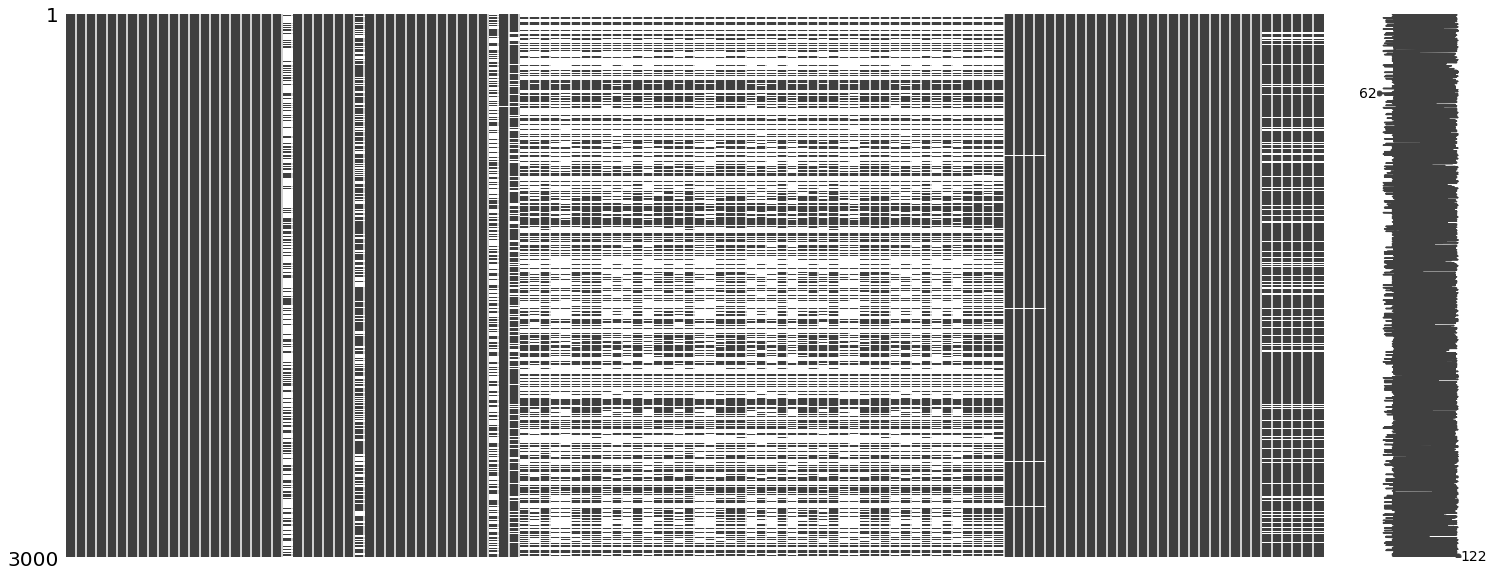

In [7]:
msno.matrix(df.sample(3000))

In [8]:
df_missing_pct = (df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False).round(1)
df_missing_pct[df_missing_pct>40]

commonarea_medi                 69.9
commonarea_avg                  69.9
commonarea_mode                 69.9
nonlivingapartments_mode        69.4
nonlivingapartments_avg         69.4
nonlivingapartments_medi        69.4
fondkapremont_mode              68.4
livingapartments_mode           68.4
livingapartments_avg            68.4
livingapartments_medi           68.4
floorsmin_avg                   67.8
floorsmin_mode                  67.8
floorsmin_medi                  67.8
years_build_medi                66.5
years_build_mode                66.5
years_build_avg                 66.5
own_car_age                     66.0
landarea_medi                   59.4
landarea_mode                   59.4
landarea_avg                    59.4
basementarea_medi               58.5
basementarea_avg                58.5
basementarea_mode               58.5
ext_source_1                    56.4
nonlivingarea_mode              55.2
nonlivingarea_avg               55.2
nonlivingarea_medi              55.2
e

In 49 columns over 40% of values are missing! Most of these columns are related to the apartment description, such as number of living rooms etc. The notable exception is `ext_source_1`, ehich is an external score and can be usefule to predict creditworthiness. 

Let's remove all thee columns except `ext_source_1`.

In [9]:
keep_columns = df_missing_pct[df_missing_pct <= 40].index.tolist() + ['ext_source_1']
df = df[keep_columns]
len(df.columns)

74

### Columns: external scores

Before dropping external score column, let's investigate of it has a relationship with the target variable. For a quick analysis are going to bin the values and compute the mean target value (expected probability of default) for each value group.

Blue bars represent expected rate of default in each group, red line - average expected rate of default.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'External Score & Default Rate')

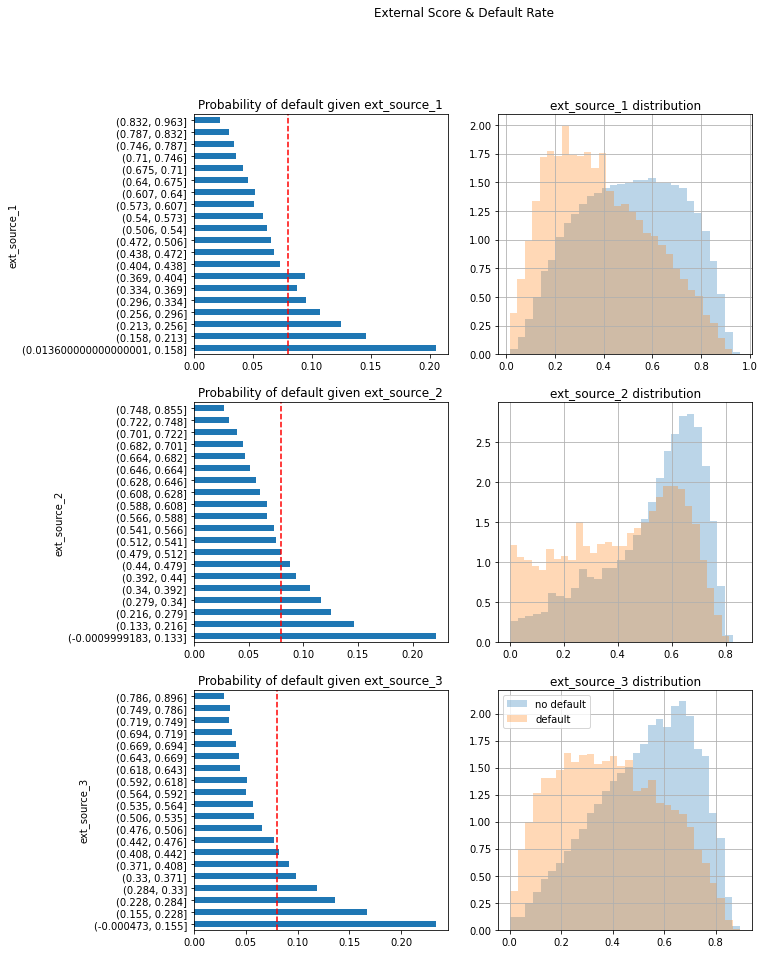

In [10]:
EXTERNAL_SCORES_COLUMNS = ['ext_source_1', 'ext_source_2', 'ext_source_3']

def plot_rate_default(col, ax):
    df.groupby(pd.qcut(df[col], 20), dropna=False).mean() \
        .target.plot.barh(ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=0.08, ymin=ymin, ymax=ymax, color='red', ls='--')
    ax.set_title(f'Probability of default given {col}')

def plot_score_distr(col, ax):
    df[df.target==0][col].hist(bins=30, density=True, alpha=0.3, label='no default', ax=ax)
    df[df.target==1][col].hist(bins=30, density=True, alpha=0.3, label='default', ax=ax)

    plt.legend()
    ax.set_title(f'{col} distribution')

fig, axs = plt.subplots(3, 2, figsize=(10,15))
for col, row in zip(EXTERNAL_SCORES_COLUMNS, axs):
    plot_rate_default(col, row[0])
    plot_score_distr(col, row[1])
    
fig.suptitle('External Score & Default Rate')

In [11]:
# what about applications with missing external score?
for score in EXTERNAL_SCORES_COLUMNS:
    print(f'{score}: {df[df[score].isnull()].target.mean()}')

ext_source_1: 0.08519535350505832
ext_source_2: 0.07878787878787878
ext_source_3: 0.09311900270647093


There is a clear relationship. Proportion of defaults is rising together with the score. We are going to use the following cutoffs:
 * score 1: reject application if score is below 0.2
 * score 2: reject application if score is below 0.25
 * score 3: reject application if score is below 0.27

### Time values: age, days employed

Days of birth are records relative to the date of appplication, hence the negatove numbers. Let's divide by -365 and plot applicants age.

<AxesSubplot:>

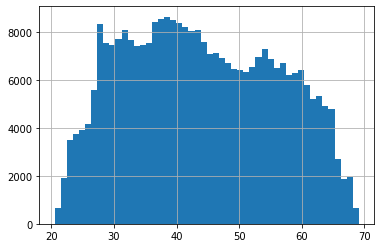

In [12]:
(df.days_birth / -365).hist(bins=50)

Text(0.5, 1.0, 'Probability of default given age')

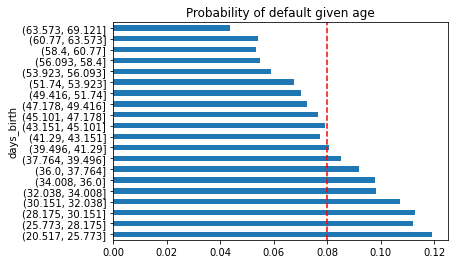

In [13]:
df.groupby(pd.qcut(df.days_birth / -365, 20), dropna=False).mean() \
        .target.plot.barh()
ymin, ymax = plt.ylim()
plt.vlines(x=0.08, ymin=ymin, ymax=ymax, color='red', ls='--')
plt.title('Probability of default given age')

This looks quite realist, no visible outliers.

We also binned age and plotted rate of default for each age group. As expected, there is a higher rate for younger applicatants. Howver, that could simply be the effect of employment. Younger clients (25-) couls still be students, earn less due to less years of ecperience etc. We should not discount them just due to age.

Lte's now look at years employed.

<AxesSubplot:>

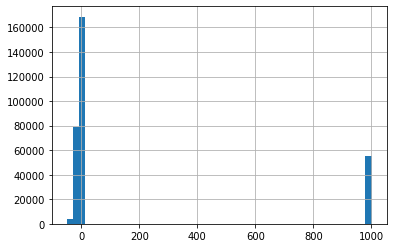

In [321]:
(df['days_employed'] / 365).hist(bins=50)

Hmm, this is weird, how can anyone be employed for 1000 years? It's unlikely that our clients are vampires :) 

In [322]:
df['days_employed'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: days_employed, Length: 12574, dtype: int64

/tmp/ipykernel_322/1771448759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_employed_anomaly'] = df["days_employed"] == 365243
/tmp/ipykernel_322/1771448759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_employed'].replace({365243: np.nan}, inplace = True)


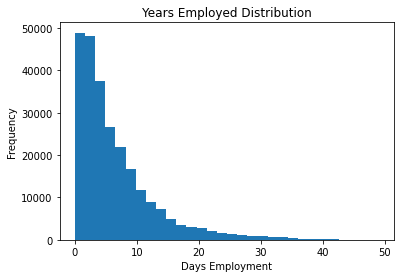

In [14]:
# Create an anomalous flag column
df['days_employed_anomaly'] = df["days_employed"] == 365243

# Replace the anomalous values with nan
df['days_employed'].replace({365243: np.nan}, inplace = True)

(df['days_employed']/-365).plot.hist(title = 'Years Employed Distribution', bins=30);
plt.xlabel('Days Employment');

Text(0.5, 1.0, 'Probability of default given years of employment')

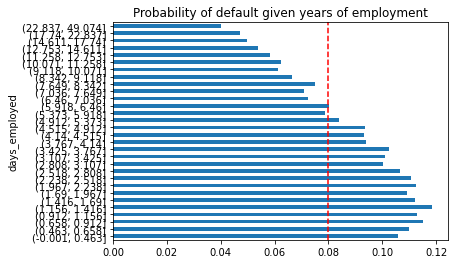

In [15]:
df.groupby(pd.qcut(df.days_employed / -365, 30), dropna=False).mean() \
        .target.plot.barh()
ymin, ymax = plt.ylim()
plt.vlines(x=0.08, ymin=ymin, ymax=ymax, color='red', ls='--')
plt.title('Probability of default given years of employment')

In [18]:
df[df.days_employed / -365 > 1].target.mean()

0.0837143940576833

In [19]:
for months_employed in [1,3,6,9,12, 24, 36]:
    mask = (months_employed - 1 <= df.days_employed / -30) & (df.days_employed / -30 <= months_employed)
    prob_def = df[mask].target.mean()*100
    print(f'Probability of default when employed {months_employed} months: {prob_def}.')

Probability of default when employed 1 months: 16.666666666666664.
Probability of default when employed 3 months: 10.40268456375839.
Probability of default when employed 6 months: 10.841313269493844.
Probability of default when employed 9 months: 12.086513994910941.
Probability of default when employed 12 months: 11.048478015783541.
Probability of default when employed 24 months: 11.248131539611359.
Probability of default when employed 36 months: 9.72668810289389.


Text(0.5, 42.0, 'Months employed')

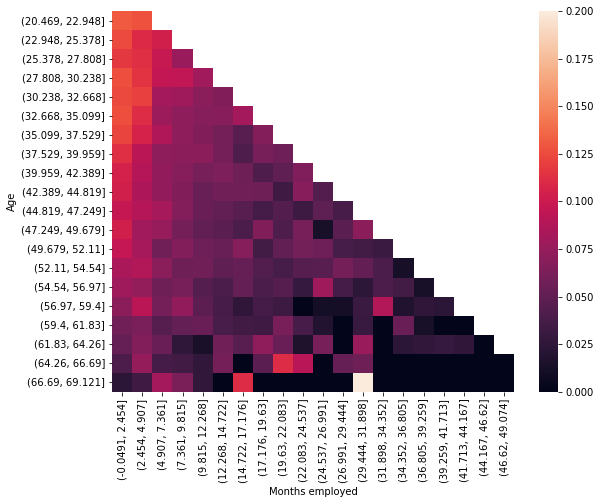

In [20]:
plt.figure(figsize=(9,7))
heatmap_df = df.groupby([pd.cut(df.days_birth / -365, 20),
                         pd.cut(df.days_employed / -365, 20)])\
    .mean().target.unstack()
sns.heatmap(heatmap_df)
plt.ylabel('Age')
plt.xlabel('Months employed')

In [383]:
df[['sk_id_curr', 'target']]

,sk_id_curr,target
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0
...,...,...
307506,456251,0
307507,456252,0
307508,456253,0
307509,456254,1


In [401]:
col

'amt_req_credit_bureau_year'

In [28]:
list(df.iloc[0].to_dict())

['occupation_type',
 'ext_source_3',
 'amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_qrt',
 'amt_req_credit_bureau_year',
 'name_type_suite',
 'obs_30_cnt_social_circle',
 'def_30_cnt_social_circle',
 'obs_60_cnt_social_circle',
 'def_60_cnt_social_circle',
 'ext_source_2',
 'amt_goods_price',
 'amt_annuity',
 'cnt_fam_members',
 'days_last_phone_change',
 'cnt_children',
 'flag_document_8',
 'name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_document_2',
 'flag_document_3',
 'flag_document_4',
 'flag_document_5',
 'flag_document_6',
 'flag_document_7',
 'flag_document_9',
 'flag_document_21',
 'flag_document_10',
 'flag_document_11',
 'flag_own_realty',
 'flag_document_13',
 'flag_document_14',
 'flag_document_15',
 'flag_document_16',
 'flag_document_17',
 'flag_document_18',
 'flag_document_19',
 'flag_document_20',
 'flag_document_12',
 'amt_credit',
 'amt_income_total',
 'f

In [577]:
# Get probability of default for each group
AVG_DEFAULT_RATE = df.target.mean()
ACCEPTABLE_DEFAULT_RATE = AVG_DEFAULT_RATE * 1.10

df_bins = df[['sk_id_curr', 'target']]
bins_map = dict()
bins_dict = dict()

for col in df.select_dtypes('number'):
    if col not in ['target', 'sk_id_curr', 'cnt_children_bin_val']:
        if df[col].nunique() < 20:
            q = df[col].nunique()
        else:
            q = 20
        # apply and save qcut bins
        binned, bins = pd.qcut(df[col], q, duplicates='drop', retbins=True, labels=False)
        bins_dict[col] = bins
        bins_map[col] = df.groupby(binned).target.mean()


In [581]:
df_copy = df.copy()
for col in df.select_dtypes('number')\
    .drop(['target', 'sk_id_curr', 'cnt_children_bin_val'], axis=1).columns:
        df_copy[col] = pd.cut(df[col], bins=bins_dict[col], labels=False, include_lowest=True)\
            .map(bins_map[col])
        
prob_default = df_copy.select_dtypes('number')\
    .drop(['target', 'sk_id_curr', 'cnt_children_bin_val'], axis=1)\
    .mean(1)

df_final = df[['sk_id_curr', 'target']].copy()
df_final['prob'] = prob_default
df_final['pred'] = (df_final['prob'] > df.target.mean()*1).astype(int)

In [582]:
df_final[df_final.pred == 0].target.mean()

0.05554265281350377

In [583]:
df_final[df_final.pred == 1].target.mean()

0.15320018157058557

In [573]:
from sklearn.metrics import ConfusionMatrixDisplay

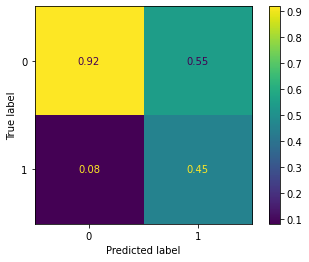

In [574]:
ConfusionMatrixDisplay.from_predictions(df_final.target, df_final.pred, normalize='pred')

In [591]:
class MeanBinDefaultRate:
    DROP_COLS = ['target', 'sk_id_curr']
    def __init__(self, margin:float=0):
        self.bins_dict = dict()
        self.bins_map = dict()
        
        self.margin = 0
        
    @staticmethod
    def get_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Get a subset of data only with numeric columns."""
        return df.select_dtypes('number').drop(MeanBinDefaultRate.DROP_COLS, axis=1)
        
    def fit(self, df):
        """Create bins for all numeric columns and save default rate for each bin."""
        for col in MeanBinDefaultRate.get_numeric_columns(df).columns:
            # use 20 bins if number of unique valeus exceeds 20
            if df[col].nunique() < 20:
                q = df[col].nunique()
            else:
                q = 20
                
            # apply and save qcut bins
            binned, bins_ = pd.qcut(df[col], q, duplicates='drop',
                                   retbins=True, labels=False)

            self.bins_dict[col] = bins_
            self.bins_map[col] = df.groupby(binned).target.mean()
        
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Get average default rate for each column.
        
        Return average of all columns.
        """
        df_copy = df.copy()
        for col in MeanBinDefaultRate.get_numeric_columns(df).columns:
                df_copy[col] = pd.cut(df[col], bins=self.bins_dict[col], labels=False,
                                      include_lowest=True)\
                    .map(self.bins_map[col])

        prob_default = MeanBinDefaultRate.get_numeric_columns(df_copy).mean(1)

        probs = (prob_default > df.target.mean()*(1+ self.margin)).astype(int)
        return probs


In [592]:
mbdr = MeanBinDefaultRate()

mbdr.fit(df)

In [ ]:
mbdr.transform(df)

## Categorical Variables

In [215]:
# Number of unique classes in each object column
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

occupation_type               18
name_type_suite                7
name_contract_type             2
code_gender                    3
flag_own_car                   2
flag_own_realty                2
weekday_appr_process_start     7
organization_type             58
name_housing_type              6
name_family_status             6
name_education_type            5
name_income_type               8
dtype: int64

In [216]:
get_target_share = lambda x: x.divide(x.sum(), axis=1).T

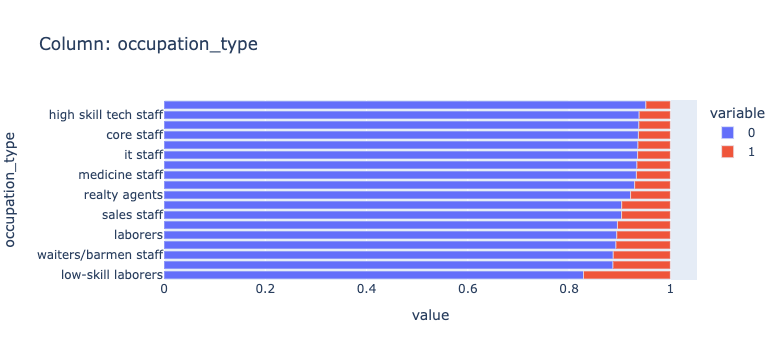

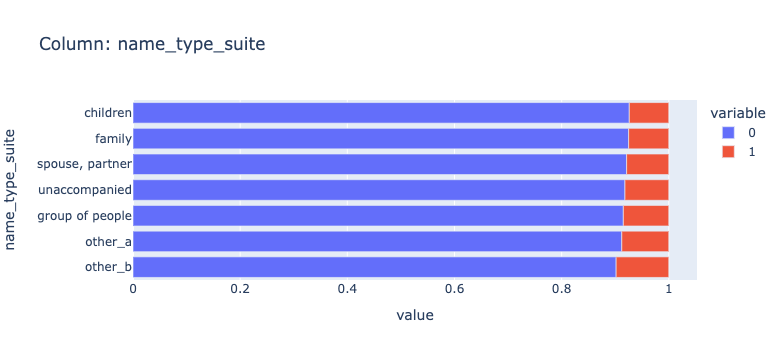

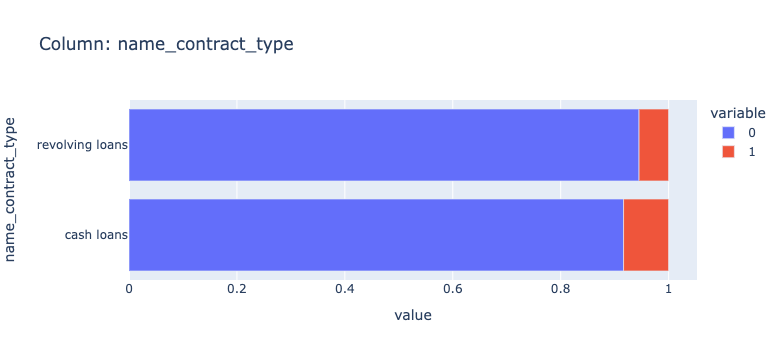

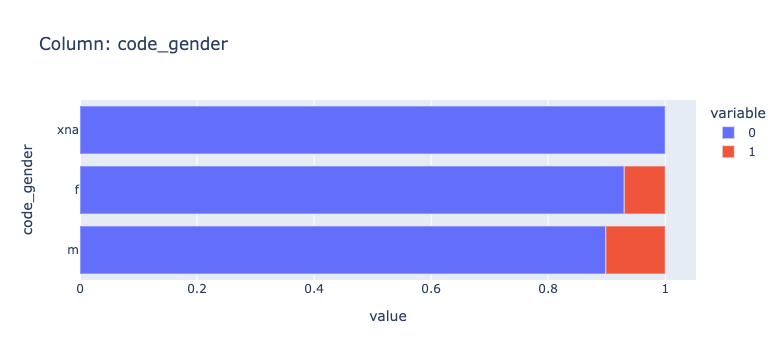

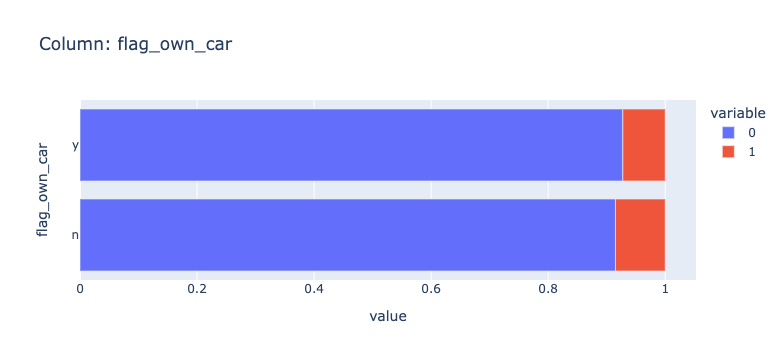

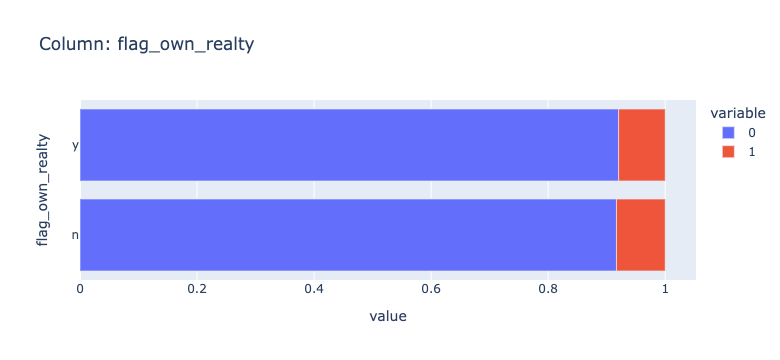

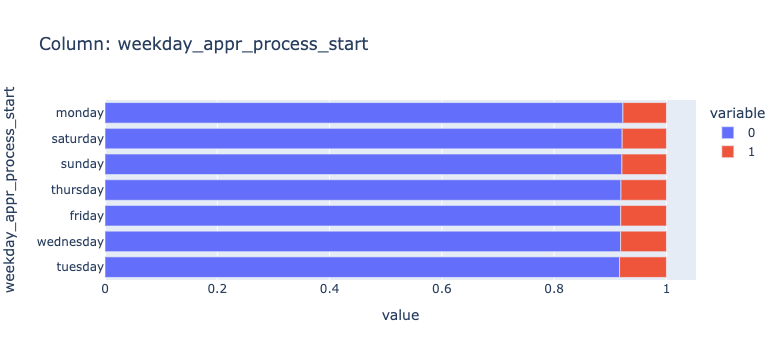

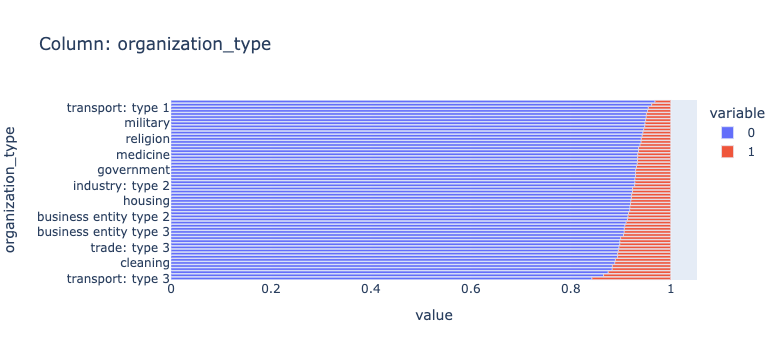

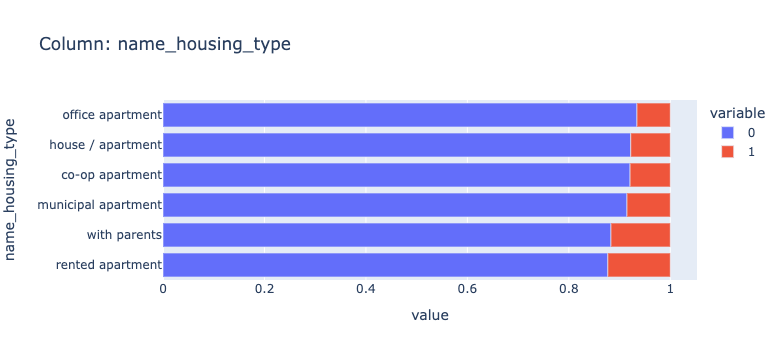

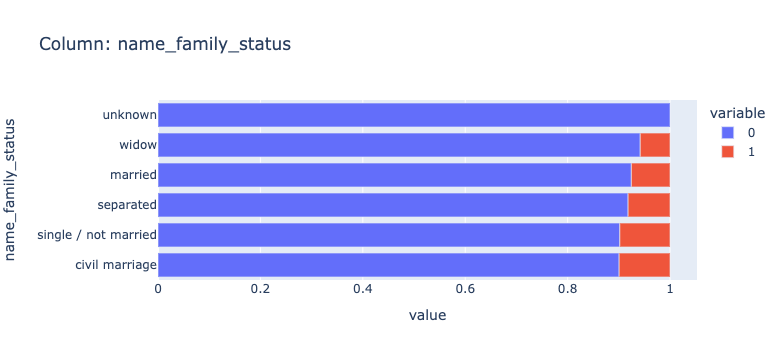

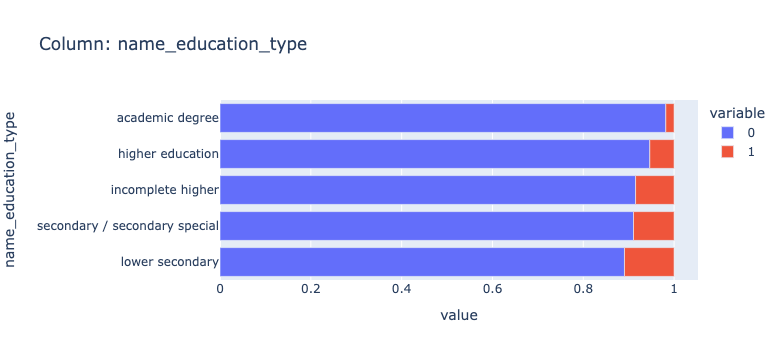

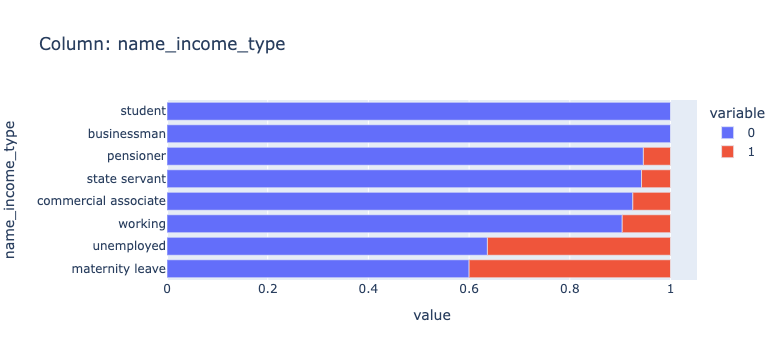

In [233]:
for col in df.select_dtypes(object).columns:
    by_target = df.groupby(['target', col]).count().sk_id_curr.unstack()
    source = get_target_share(by_target).sort_values(by=0).reset_index()

    fig = px.bar(source, y=col, x=[0,1], title=f"Column: {col}")
    fig.show()

Let's take a closer look at some categories.

**income type** Those with type "maternity" or "unemployed" have higher chances of default, as expected. Interestingly though, students have very low number of defaults.

**name_education_type**: those with less education tend to have higher default rate.

**name_housing_type**: those that live with parents have higher than average chance of default at 12%. Those that live in rented apartments have similar values.

**name_occupation_type**: waiters, drives and low skilled laborere have a probability of default > 10% (on average).

Text(0.5, 1.0, 'Kendall Correlation with the Default')

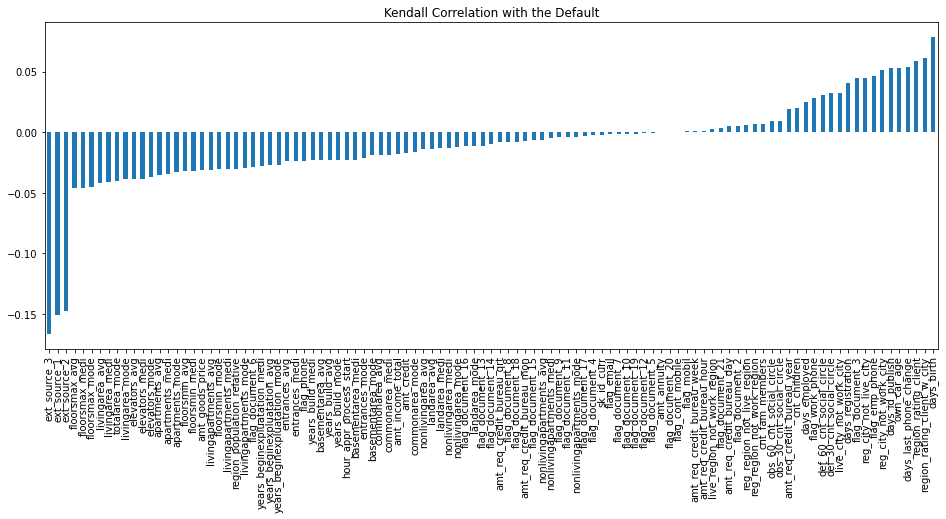

In [180]:
plt.figure(figsize=(16,6))
df.corr('spearman').target.sort_values().drop('target').plot.bar()
plt.title('Spearman Correlation with the Default')

## Dataset: Bureau

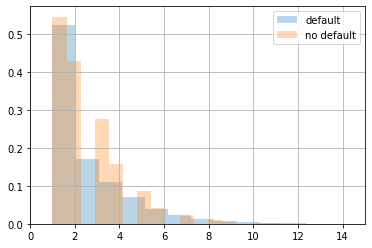

In [52]:
num_active_credits = data_io['bureau'].query('credit_active == "active"')\
.groupby('sk_id_curr').count()\
.sk_id_bureau.reset_index()

dd = data_io['applications'][['sk_id_curr', 'target']]\
    .merge(num_active_credits, on='sk_id_curr')

dd[dd.target == 1].sk_id_bureau.hist(alpha=0.3,
                                     density=True,
                                    label='default',
                                    bins=30)
dd[dd.target == 0].sk_id_bureau.hist(alpha=0.3,
                                     density=True,
                                    label='no default',
                                    bins=30)
plt.xlim(xmin=0, xmax=15)
plt.legend()

Text(0.5, 1.0, 'Number of previous credits')

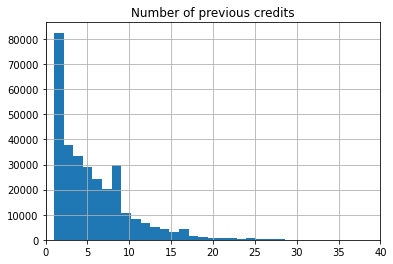

In [33]:
#data_io['bureau'].groupby('sk_id_curr').count().sk_id_bureau\
#    .value_counts().iloc[:10].plot.barh()
data_io['bureau'].groupby('sk_id_curr').count()\
.sk_id_bureau.hist(bins=100)
plt.xlim(xmin=0, xmax=40)
plt.title('Number of previous credits')

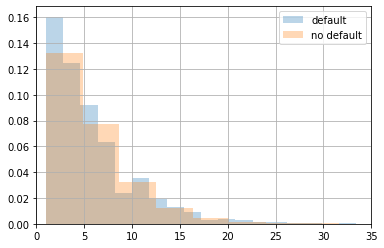

In [44]:
dd = data_io['applications'][['sk_id_curr', 'target']]\
    .merge(data_io['bureau'].groupby('sk_id_curr').count()\
    .sk_id_bureau.reset_index(), on='sk_id_curr')

dd[dd.target == 1].sk_id_bureau.hist(alpha=0.3,
                                     density=True,
                                    label='default',
                                    bins=30)
dd[dd.target == 0].sk_id_bureau.hist(alpha=0.3,
                                     density=True,
                                    label='no default',
                                    bins=30)
plt.xlim(xmin=0, xmax=35)
plt.legend()

In [34]:
[col for col in data_io['applications'].columns if 'days' in col]

['days_birth',
 'days_employed',
 'days_registration',
 'days_id_publish',
 'days_last_phone_change']

In [11]:
data_io['applications'].corr().sk_id_curr.sort_values()

flag_document_4            -0.004139
flag_document_3            -0.003411
nonlivingapartments_medi   -0.003020
cnt_fam_members            -0.002895
entrances_avg              -0.002879
                              ...   
elevators_medi              0.005067
years_build_mode            0.005245
years_build_medi            0.005777
years_build_avg             0.005900
sk_id_curr                  1.000000
Name: sk_id_curr, Length: 106, dtype: float64

## Dataset: Applications

In [7]:
data_io.describe_columns('applications')

,row,description
0,sk_id_curr,ID of loan in our sample
1,target,Target variable (1 - client with payment diffi...
2,name_contract_type,Identification if loan is cash or revolving
3,code_gender,Gender of the client
4,flag_own_car,Flag if the client owns a car
...,...,...
117,amt_req_credit_bureau_day,Number of enquiries to Credit Bureau about the...
118,amt_req_credit_bureau_week,Number of enquiries to Credit Bureau about the...
119,amt_req_credit_bureau_mon,Number of enquiries to Credit Bureau about the...
120,amt_req_credit_bureau_qrt,Number of enquiries to Credit Bureau about the...


## Target
TARGET :  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

We have just about 8% defaults. This is a very imbalanced dataset, which is normal for credit risk field. You do not expect to have a high number of defaults, making it harder to train models.

However, 8% is not that severe for such dataset, it is actually very high. You often see less than 1% defaults. 

0.08072881945686496


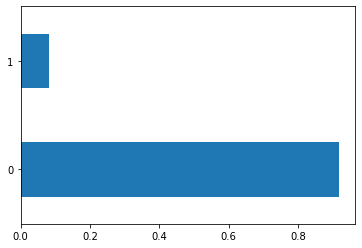

In [8]:
n_apps = data_io['applications'].shape[0]
(data_io['applications'].target.value_counts() / n_apps).plot.barh()

print(data_io['applications'].target.sum() / n_apps)

In [9]:
# making sure load ID is unique pro application
data_io['applications'].name_contract_type.unique()

array(['cash loans', 'revolving loans'], dtype=object)

# Applications Data

In [10]:
class TargetData:
    REQUIRED_DATASETS = ['applications']
    
    def __init__(self, data_io:DataIO):
        self.data_io = data_io
    
    def generate_target(self) -> pd.DataFrame:
        df = self.data_io['applications'].copy()
        self.dataset = df[['sk_id_curr', 'target']]
        
        return self.dataset
    
TargetData(data_io=data_io).generate_target().head(1)

,sk_id_curr,target
0,100002,1


In [11]:
class SkipAggregator:
    """Skip aggregations."""
    
    REQUIRED_DATASETS = list()
    
    @classmethod
    def name(cls):
        return 'skipper'
    
    
    def aggregate(self, data_io, output_dataset_name:str):
        return data_io[output_dataset_name]

## Idea: Aggregate -> Transform + New features (not result of aggregation)
Attr: `features_` - all that is not index

`FeatureGenerator` = `DataAggregator` + `TransformerStack`

`DataAggregator`: takes in `DataIO` object (with dataset `dict`), returns a _single_ dataset.
`TransformerStack`: takes in a single `pd.DataFrame`, returns also a single `pd.DataFrame`.

`ApplicationFeatures` = `SkipAggregator` + `Stack([OneHotEncoderWithMemory, ])`

FeatureGenerator:
* applied data aggregator to combine required daatsets into one
* processes aggregated columns (single column)
* Adds new features that combine columns (several columns)

In [12]:
class ApplicationFeatures:
    
    BIN_FEATURES = ['code_gender', 'flag_own_car', 'flag_own_realty']
    REQUIRED_DATASETS = ['applications']
    
    def __init__(self, data_io:DataIO):
        self.data_io = data_io
    
    @classmethod
    def preprocess(cls, df: pd.DataFrame) -> pd.DataFrame:
        # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
        df.drop('target', axis=1, inplace=True)
        df = df[df['code_gender'] != 'XNA']

        # Categorical features with Binary encode (0 or 1; two categories)
        for bin_feature in cls.BIN_FEATURES:
            df.loc[:, bin_feature], uniques = pd.factorize(df.loc[:, bin_feature])
        # Categorical features with One-Hot encode
        encoder = OneHotEncoderWithMemory(nan_category=False)
        df = encoder.fit_transform(df)
        
        # NaN values for days_employed: 365.243 -> nan
        df['days_employed'].replace(365243, np.nan, inplace= True)
        
        return df
    
    @staticmethod
    def add_new_features(df):
         # Some simple new features (percentages)
        df['days_employed_perc'] = df['days_employed'] / df['days_birth']
        df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
        df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
        df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
        df['payment_rate'] = df['amt_annuity'] / df['amt_credit']
        return df
    
    def generate_features(self):
        df = self.data_io['applications'].copy()
        print("Samples: {}".format(len(df)))
        
        df = ApplicationFeatures.preprocess(df)
        df = ApplicationFeatures.add_new_features(df)
        
        gc.collect()
        
        self.dataset = df
        
        return df

In [15]:
app_f = ApplicationFeatures(data_io=data_io)
app_f.REQUIRED_DATASETS

['applications']

In [16]:
app_f.generate_features().head(1)

Samples: 307511


,sk_id_curr,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,wallsmaterial_mode_panel,"wallsmaterial_mode_stone, brick",wallsmaterial_mode_wooden,emergencystate_mode_no,emergencystate_mode_yes,days_employed_perc,income_credit_perc,income_per_person,annuity_income_perc,payment_rate
0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749


In [17]:
app_f.dataset.columns

Index(['sk_id_curr', 'code_gender', 'flag_own_car', 'flag_own_realty',
       'cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity',
       'amt_goods_price', 'region_population_relative',
       ...
       'wallsmaterial_mode_panel', 'wallsmaterial_mode_stone, brick',
       'wallsmaterial_mode_wooden', 'emergencystate_mode_no',
       'emergencystate_mode_yes', 'days_employed_perc', 'income_credit_perc',
       'income_per_person', 'annuity_income_perc', 'payment_rate'],
      dtype='object', length=246)

In [39]:
class TrainingData:
    
    def __init__(self, data_io: DataIO,
                       target: TargetData,
                       app_data: ApplicationFeatures,
                       merge_on='sk_id_curr'):
        self.target = target(data_io=data_io)
        self.app_data = app_data(data_io=data_io)
        self.merge_on = merge_on
        
    def generate_training_dataset(self):
        self.target.generate_target()
        self.app_data.generate_features()
        
        df = self.target.dataset.merge(self.app_data.dataset, how='left', on=self.merge_on)
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        self.training_data = df
                
        return df

In [40]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [41]:
# full scripts

data_generator = TrainingData(data_io=data_io,
                              target=TargetData,
                              app_data=ApplicationFeatures,
                              merge_on='sk_id_curr')

data = data_generator.generate_training_dataset()

# split into X and y
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# train & eval
estimator = LGBMClassifier()
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
# scores = cross_val_score(LGBMClassifier(), X, y, cv=5)
eval_results = pd.DataFrame({'preds': preds, 'actuals': y_test})

Samples: 307511


In [47]:
recall_score(y_test, preds)

0.020164499867338818

In [48]:
precision_score(y_test, preds)

0.5135135135135135

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, RocCurveDisplay

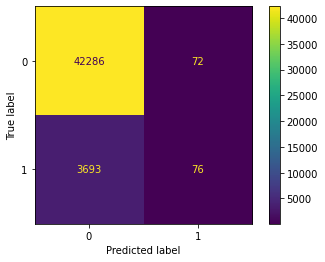

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, preds)

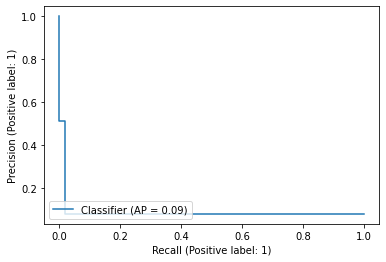

In [50]:
PrecisionRecallDisplay.from_predictions(y_test, preds)

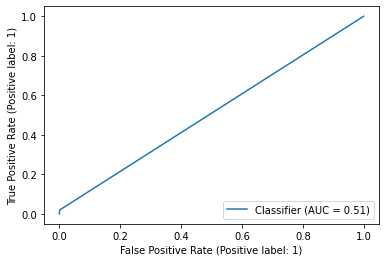

In [52]:
RocCurveDisplay.from_predictions(y_test, preds)

# After training

* save model
* save eval results

Later: model versioning

Create a model folder (version/timestamp)
Save model (joblib) and eval_results dir with plots

In [55]:
class Estimator:
    
    def __init__(self):
        self.model = None
        
    @classmethod
    def from_params(cls, params=dict()):
        return LGBMClassifier(**params)
    
    def serialize(self, filename:str='model_jlib'):
        joblib.dump(self.model , filename)
        
    def load(self, filename:str='model_jlib'):
        model = joblib.load(filename)
        return model

In [ ]:
MODEL_DIR = 'models'

SAVE_DIR = 'models'

In [54]:
import joblib

In [ ]:
joblib.dump(model , 'model_jlib')

## Bureau

In [60]:
data_io['bureau']

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,consumer credit,-131,NaN
1,215354,5714463,active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,credit card,-20,NaN
2,215354,5714464,active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,consumer credit,-16,NaN
3,215354,5714465,active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,credit card,-16,NaN
4,215354,5714466,active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,microloan,-19,NaN
1716424,100044,5057754,closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,consumer credit,-2493,NaN
1716425,100044,5057762,closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,consumer credit,-967,NaN
1716426,246829,5057770,closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,consumer credit,-1508,NaN


<AxesSubplot:xlabel='credit_type'>

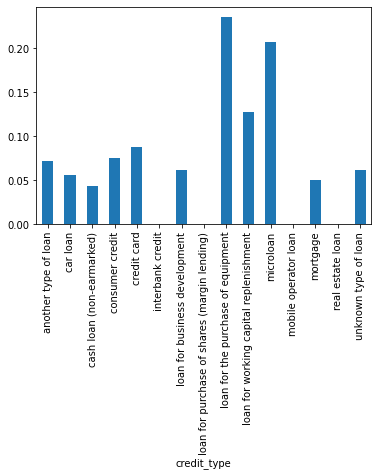

In [69]:
data_io['applications'][['sk_id_curr', 'target']]\
    .merge(data_io['bureau'][['sk_id_curr', 'credit_type']], on='sk_id_curr', how='left')\
    .groupby('credit_type').mean().target.plot.bar()

In [62]:
encoder1 = OneHotEncoderWithMemory(nan_category=False)
bureau = encoder1.fit_transform(data_io['bureau'])
bureau_cat = encoder1.encoded_columns_

encoder2 = OneHotEncoderWithMemory(nan_category=False)
bb = encoder2.fit_transform(data_io['bureau_balance'])
bb_cat = encoder2.encoded_columns_

In [63]:
bureau

,sk_id_curr,sk_id_bureau,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,...,credit_type_interbank credit,credit_type_loan for business development,credit_type_loan for purchase of shares (margin lending),credit_type_loan for the purchase of equipment,credit_type_loan for working capital replenishment,credit_type_microloan,credit_type_mobile operator loan,credit_type_mortgage,credit_type_real estate loan,credit_type_unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,...,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
a = 'credit_type_loan for purchase of shares (margin lending)'
a.replace(' ', '_')\
 .replace('-', '_')\
 .replace('(', '')\
 .replace(')', '')

clean_str = lambda s: s.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')

def clean_column_names(df:pd.DataFrame) -> pd.DataFrame:
    df.columns = [clean_str(col) for col in df.columns]
    return df

In [49]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'months_balance': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('sk_id_bureau').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='sk_id_bureau')
bureau.drop(['sk_id_bureau'], axis=1, inplace= True)

In [50]:
#bureau = clean_column_names(bureau)
del bb, bb_agg
gc.collect()

0

In [51]:
bureau.columns

Index(['sk_id_curr', 'days_credit', 'credit_day_overdue',
       'days_credit_enddate', 'days_enddate_fact', 'amt_credit_max_overdue',
       'cnt_credit_prolong', 'amt_credit_sum', 'amt_credit_sum_debt',
       'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'days_credit_update',
       'amt_annuity', 'credit_active_active', 'credit_active_bad debt',
       'credit_active_closed', 'credit_active_sold',
       'credit_currency_currency 1', 'credit_currency_currency 2',
       'credit_currency_currency 3', 'credit_currency_currency 4',
       'credit_type_another type of loan', 'credit_type_car loan',
       'credit_type_cash loan (non-earmarked)', 'credit_type_consumer credit',
       'credit_type_credit card', 'credit_type_interbank credit',
       'credit_type_loan for business development',
       'credit_type_loan for purchase of shares (margin lending)',
       'credit_type_loan for the purchase of equipment',
       'credit_type_loan for working capital replenishment',
       '

In [52]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'days_credit': ['min', 'max', 'mean', 'var'],
    'days_credit_enddate': ['min', 'max', 'mean'],
    'days_credit_update': ['mean'],
    'credit_day_overdue': ['max', 'mean'],
    'amt_credit_max_overdue': ['mean'],
    'amt_credit_sum': ['max', 'mean', 'sum'],
    'amt_credit_sum_debt': ['max', 'mean', 'sum'],
    'amt_credit_sum_overdue': ['mean'],
    'amt_credit_sum_limit': ['mean', 'sum'],
    'amt_annuity': ['max', 'mean'],
    'cnt_credit_prolong': ['sum'],
    'months_balance_min': ['min'],
    'months_balance_max': ['max'],
    'months_balance_size': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_mean"] = ['mean']

In [53]:
cat_aggregations

{'credit_active_active': ['mean'],
 'credit_active_bad debt': ['mean'],
 'credit_active_closed': ['mean'],
 'credit_active_sold': ['mean'],
 'credit_currency_currency 1': ['mean'],
 'credit_currency_currency 2': ['mean'],
 'credit_currency_currency 3': ['mean'],
 'credit_currency_currency 4': ['mean'],
 'credit_type_another type of loan': ['mean'],
 'credit_type_car loan': ['mean'],
 'credit_type_cash loan (non-earmarked)': ['mean'],
 'credit_type_consumer credit': ['mean'],
 'credit_type_credit card': ['mean'],
 'credit_type_interbank credit': ['mean'],
 'credit_type_loan for business development': ['mean'],
 'credit_type_loan for purchase of shares (margin lending)': ['mean'],
 'credit_type_loan for the purchase of equipment': ['mean'],
 'credit_type_loan for working capital replenishment': ['mean'],
 'credit_type_microloan': ['mean'],
 'credit_type_mobile operator loan': ['mean'],
 'credit_type_mortgage': ['mean'],
 'credit_type_real estate loan': ['mean'],
 'credit_type_unknown typ

In [54]:
bureau_agg = bureau.groupby('sk_id_curr').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [55]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['credit_active_active'] == 1]
active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
del active, active_agg
gc.collect()

0

In [56]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['credit_active_closed'] == 1]
closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
del closed, closed_agg, bureau
gc.collect()

0

In [57]:
bureau_agg

,buro_days_credit_MIN,buro_days_credit_MAX,buro_days_credit_MEAN,buro_days_credit_VAR,buro_days_credit_enddate_MIN,buro_days_credit_enddate_MAX,buro_days_credit_enddate_MEAN,buro_days_credit_update_MEAN,buro_credit_day_overdue_MAX,buro_credit_day_overdue_MEAN,...,closed_amt_credit_sum_overdue_MEAN,closed_amt_credit_sum_limit_MEAN,closed_amt_credit_sum_limit_SUM,closed_amt_annuity_MAX,closed_amt_annuity_MEAN,closed_cnt_credit_prolong_SUM,closed_months_balance_min_MIN,closed_months_balance_max_MAX,closed_months_balance_size_MEAN,closed_months_balance_size_SUM
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [ ]:
class BureauFeatures:
    
    BIN_FEATURES = ['code_gender', 'flag_own_car', 'flag_own_realty']
    REQUIRED_DATASETS = ['bureau', 'bureau_balance']
    
    num_aggregations = {
        'days_credit': ['min', 'max', 'mean', 'var'],
        'days_credit_enddate': ['min', 'max', 'mean'],
        'days_credit_update': ['mean'],
        'credit_day_overdue': ['max', 'mean'],
        'amt_credit_max_overdue': ['mean'],
        'amt_credit_sum': ['max', 'mean', 'sum'],
        'amt_credit_sum_debt': ['max', 'mean', 'sum'],
        'amt_credit_sum_overdue': ['mean'],
        'amt_credit_sum_limit': ['mean', 'sum'],
        'amt_annuity': ['max', 'mean'],
        'cnt_credit_prolong': ['sum'],
        'months_balance_min': ['min'],
        'months_balance_max': ['max'],
        'months_balance_size': ['mean', 'sum']
    }
    
    def __init__(self, data_io):
        self.data_io = data_io
    
    def preprocess(self) -> tuple
        encoder1 = OneHotEncoderWithMemory(nan_category=False)
        bureau = encoder1.fit_transform(self.data_io['bureau'])
        self.bureau_cat_ = encoder1.encoded_columns_

        encoder2 = OneHotEncoderWithMemory(nan_category=False)
        bb = encoder2.fit_transform(self.data_io['bureau_balance'])
        self.bb_cat_ = encoder2.encoded_columns_
        
        return bureau, bb
    
    def aggregate(bureau, bb):
        # Bureau balance: Perform aggregations and merge with bureau.csv
        bb_aggregations = {'months_balance': ['min', 'max', 'size']}
        for col in bb_cat:
            bb_aggregations[col] = ['mean']
        bb_agg = bb.groupby('sk_id_bureau').agg(bb_aggregations)
        bb_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in bb_agg.columns.tolist()])
        bureau = bureau.join(bb_agg, how='left', on='sk_id_bureau')
        bureau.drop(['sk_id_bureau'], axis=1, inplace= True)
        
        del bb, bb_agg
        gc.collect()
        
        # Bureau and bureau_balance categorical features
        cat_aggregations = {}
        for cat in self.bureau_cat_: cat_aggregations[cat] = ['mean']
        for cat in self.bb_cat_: cat_aggregations[cat + "_mean"] = ['mean']
        
        bureau_agg = bureau.groupby('sk_id_curr').agg({**self.num_aggregations, **self.cat_aggregations})
        bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
        
        # Bureau: Active credits - using only numerical aggregations
        active = bureau[bureau['credit_active_active'] == 1]
        active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
        active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
        del active, active_agg
        gc.collect()
        
        # Bureau: Closed credits - using only numerical aggregations
        closed = bureau[bureau['credit_active_closed'] == 1]
        closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
        closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
        del closed, closed_agg, bureau
        gc.collect()
        
        return bureau
    
    @staticmethod
    def add_new_features(df):
         # Some simple new features (percentages)
        df['days_employed_perc'] = df['days_employed'] / df['days_birth']
        df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
        df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
        df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
        df['payment_rate'] = df['amt_annuity'] / df['amt_credit']
        return df
    
    def generate_features(self):
        assert set(REQUIRED_DATASETS).issubset(set(self.data_io.list_loaded()))
        bureau, bb = self.preprocess(df)
        bureau = self.aggregate(bureau, bb)
        
        
        gc.collect()
        self.dataset = df
        
        return df

# Data Pipeline

`DatasetsFilename` - enum class to specify path for each filename

`DataIO` - Loading datasets by name. **Input**: falename (str), **output**: dict[pd.DataFrame]
* from file (parquet)
* from S3
* from SQL (S3 - Athena)

`DataAggregators` - **Input**: DataIO instance, **output**: single pd.DataFrame
`TrainingData` - **Input**: TargetDataAggregator, List[FeatureDataAggregator], **output**: single dataset
`Transformer`: **input**: pd.DataFrame, **output**: pd.DataFrame